<a href="https://colab.research.google.com/github/marcekovam/Data_science_practicum_2025/blob/main/Lesson3_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# on colab
# !pip install -qq timm

In [2]:
import timm
import os

import matplotlib.pyplot as plt
import PIL
from PIL import Image
import json

import torch
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

from fastai.vision.all import *

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## ConvNeXt


In [7]:
# Load a pre-trained deep learning model
model_name = "convnext_tiny.fb_in22k"
convnext = timm.create_model(model_name, pretrained=True).to(device)

# you can also list all models available or search through wildcard
# timm.list_models('*convnext*')

In [8]:
# Let's see the model (it's huge)
summary(convnext, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 64, 64]           4,704
       LayerNorm2d-2           [-1, 96, 64, 64]             192
          Identity-3           [-1, 96, 64, 64]               0
            Conv2d-4           [-1, 96, 64, 64]           4,800
         LayerNorm-5           [-1, 64, 64, 96]             192
            Linear-6          [-1, 64, 64, 384]          37,248
              GELU-7          [-1, 64, 64, 384]               0
           Dropout-8          [-1, 64, 64, 384]               0
          Identity-9          [-1, 64, 64, 384]               0
           Linear-10           [-1, 64, 64, 96]          36,960
          Dropout-11           [-1, 64, 64, 96]               0
              Mlp-12           [-1, 64, 64, 96]               0
         Identity-13           [-1, 96, 64, 64]               0
         Identity-14           [-1, 96,

### download label mapping for the model

In [11]:
!wget https://dl.fbaipublicfiles.com/convnext/label_to_words.json  # download the file to see categories
imagenet_labels = json.load(open('label_to_words.json'))

--2025-09-29 08:46:02--  https://dl.fbaipublicfiles.com/convnext/label_to_words.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.154.144.102, 18.154.144.74, 18.154.144.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.154.144.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 773945 (756K) [application/json]
Saving to: ‘label_to_words.json.2’

label_to_words.json 100%[===================>] 755.81K  --.-KB/s    in 0.03s   

2025-09-29 08:46:02 (22.7 MB/s) - ‘label_to_words.json.2’ saved [773945/773945]



### download random image and predict it via ConvNeXt

In [14]:
# Download random image
!wget --output-document=test.jpeg https://upload.wikimedia.org/wikipedia/commons/d/d7/Squirrel_in_Seurasaari_autumn.JPG
img = PIL.Image.open('test.jpeg')

# Define transforms for image
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

transformations = [
              transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC), # resize smaller edge to 256
              transforms.ToTensor(),
              transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
              ]

transformations = transforms.Compose(transformations)  # Image tensor (instead of image) to enter the NN

img_tensor = transformations(img).unsqueeze(0).to(device)   # pass image tensor to device

--2025-09-29 08:48:17--  https://upload.wikimedia.org/wikipedia/commons/d/d7/Squirrel_in_Seurasaari_autumn.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1338514 (1.3M) [image/jpeg]
Saving to: ‘test.jpeg’

test.jpeg           100%[===================>]   1.28M  --.-KB/s    in 0.1s    

2025-09-29 08:48:18 (12.5 MB/s) - ‘test.jpeg’ saved [1338514/1338514]



### predict label for our image

red squirrel, cat squirrel, Sciurus vulgaris 10.49%
fox squirrel, eastern fox squirrel, Sciurus niger 5.56%
American red squirrel, spruce squirrel, red squirrel, Sciurus hudsonicus, Tamiasciurus hudsonicus 4.00%
squirrel 2.53%
chickeree, Douglas squirrel, Tamiasciurus douglasi 2.33%


/tmp/ipython-input-1243644383.py:8: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  prob = "{:.2f}%".format(float(top5_prob[i])*100)


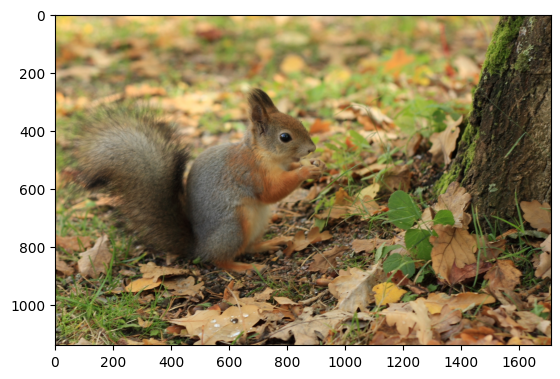

In [15]:
output = torch.softmax(convnext(img_tensor), dim=1)
top5 = torch.topk(output, k=5)
top5_prob = top5.values[0]
top5_indices = top5.indices[0]

for i in range(5):
    labels = imagenet_labels[str(int(top5_indices[i]))]
    prob = "{:.2f}%".format(float(top5_prob[i])*100)
    print(labels, prob)

plt.imshow(img)



---



## The Oxford-IIIT Pet Dataset

https://www.robots.ox.ac.uk/~vgg/data/pets/



In [16]:
# Let's work with more new data
path = untar_data(URLs.PETS)/'images'
path

Path('/root/.fastai/data/oxford-iiit-pet/images')

In [20]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),  # resize images to have the same size
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))  # use data augmentation (crop, squeeze, whatever...)

dls = pets.dataloaders(path, bs=32)  # batch size 32

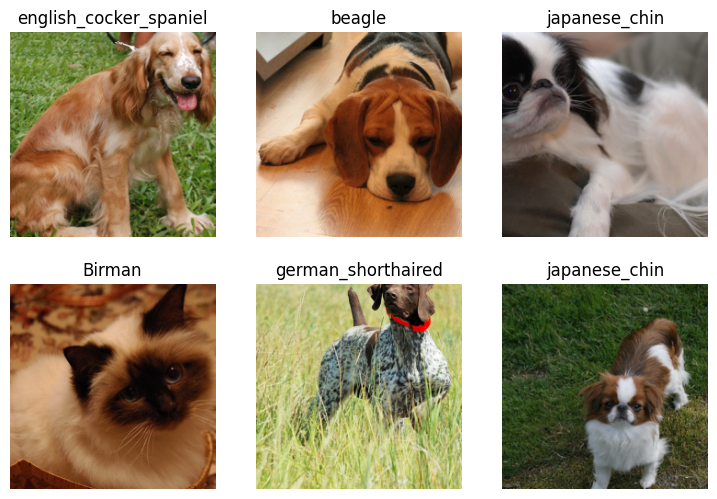

In [25]:
# Let's see the data after the transformation (croping etc. in data augmentation)
dls.show_batch(max_n=6)

## Load ConvNeXt model and fine-tune it

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 185MB/s] 


SuggestedLRs(valley=0.0012022644514217973)

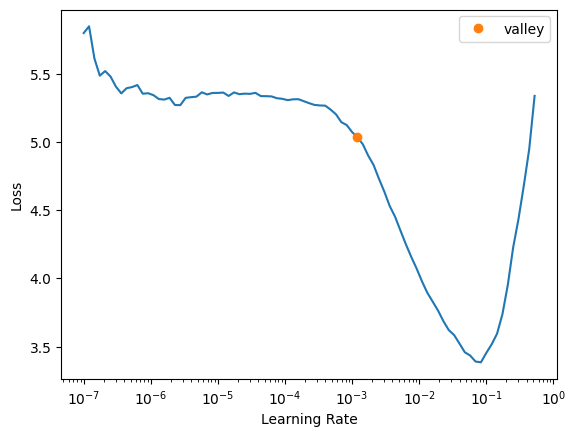

In [26]:
learn = vision_learner(dls, convnext_tiny, metrics=error_rate)
learn.lr_find()

We should use learning rate 0.0012022644514217973.

In [27]:
# We "get rid of" the end of the NN and make it ourselves - train in on our data
learn = vision_learner(dls, convnext_tiny, metrics=error_rate)
learn.fine_tune(1, 0.0012022644514217973)

epoch,train_loss,valid_loss,error_rate,time
0,0.899484,0.245175,0.081191,01:18


epoch,train_loss,valid_loss,error_rate,time
0,0.321756,0.176240,0.057510,02:00


Validation loss should be always smaller than training loss, otherwise there might be some underlaying problem hidden.

Training loss is much greater, because at the beggining of the training, the model was not good (not trained) yet.

In [28]:
learn = vision_learner(dls, convnext_tiny, metrics=error_rate)
learn.fine_tune(3, 0.0012022644514217973, freeze_epochs=1)  # now change the NN even more

epoch,train_loss,valid_loss,error_rate,time
0,0.931480,0.231731,0.081867,01:19


epoch,train_loss,valid_loss,error_rate,time
0,0.352010,0.209737,0.069012,02:00
1,0.264852,0.159494,0.051421,01:59
2,0.215987,0.151487,0.049391,02:00


## See how our model performs:


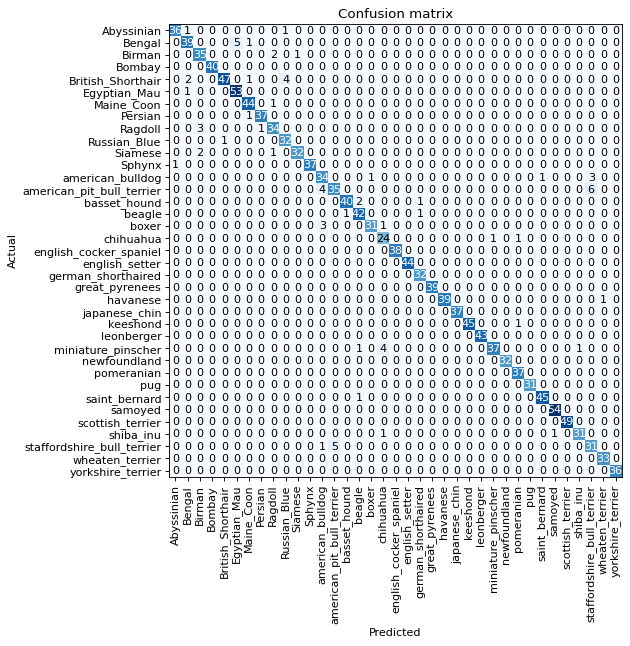

In [29]:
# Confusion matrix
# We should check problematic categories out of diagonal
# Some pets are way too similar to distinguish between them, that's why the NN makes mistakes there (even a human would)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

### What is hard to predict?

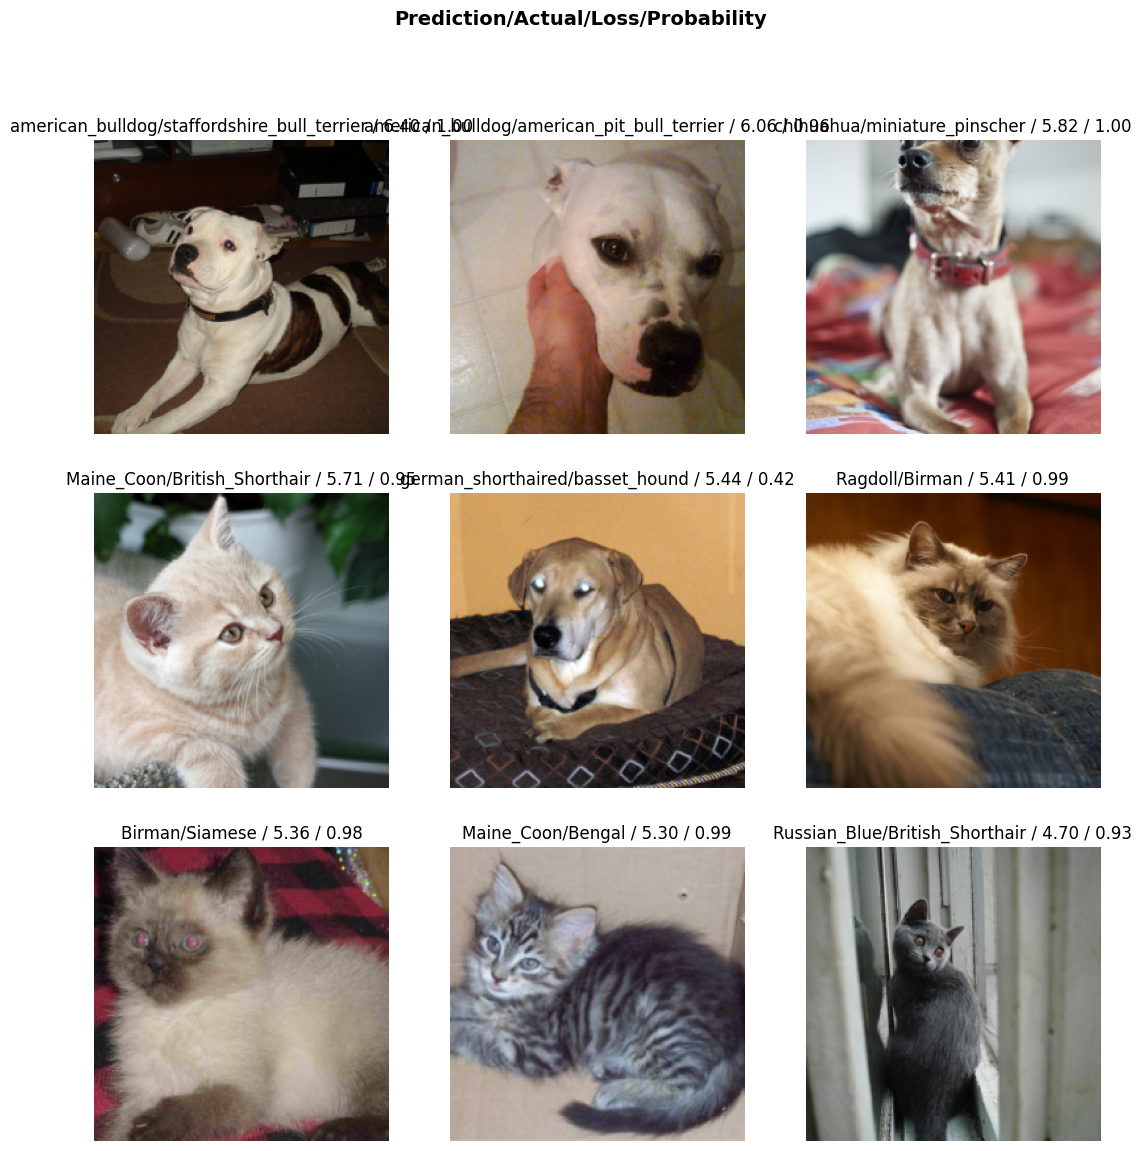

In [30]:
# This can show us where the mistakes happen
interp.plot_top_losses(9, figsize=(13,13))

## Predict a new image

In [ ]:
### uncoment this for colab
# from google.colab import files
# uploaded = files.upload()

In [ ]:
### uncoment this for colab
# img = PILImage.create(list(uploaded.values())[0])
# img

In [31]:
import ipywidgets as widgets
from IPython.display import display
import io

def upload_files():
    upload_widget = widgets.FileUpload(
        accept='image/*',  # Accept all image types
        multiple=False    # Only allow single file selection
    )
    display(upload_widget)
    return upload_widget

uploaded = upload_files()

FileUpload(value={}, accept='image/*', description='Upload')

In [32]:
from PIL import Image

if len(uploaded.value) > 0:
    first_file = uploaded.value[0]
    content = first_file['content']
    img = Image.open(io.BytesIO(content))
    display(img)
else:
    print("No file has been uploaded yet.")


No file has been uploaded yet.


In [33]:
pred,pred_idx,probs = learn.predict(img)
pred,pred_idx,probs

('Abyssinian',
 tensor(0),
 tensor([0.4548, 0.0117, 0.0021, 0.0061, 0.0172, 0.0044, 0.0010, 0.0017, 0.0009,
         0.0133, 0.0551, 0.0028, 0.0007, 0.0007, 0.0151, 0.0174, 0.0436, 0.0043,
         0.0089, 0.0344, 0.0413, 0.0020, 0.0488, 0.0029, 0.0193, 0.0262, 0.0297,
         0.0034, 0.0038, 0.0131, 0.0035, 0.0014, 0.0463, 0.0027, 0.0027, 0.0126,
         0.0440]))

## Data augmentation

use image transformations from https://docs.fast.ai/vision.augment.html

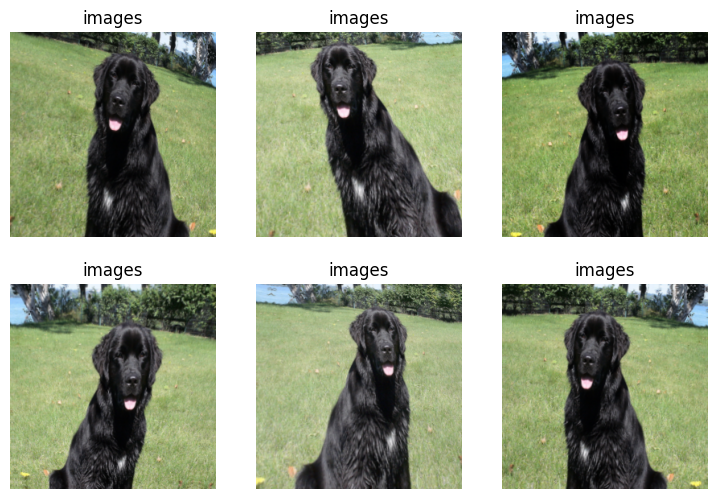

In [34]:
tfms = tfms = [
    Normalize.from_stats(*imagenet_stats),  # Normalize using ImageNet stats
    *aug_transforms(
        flip_vert=False,      # Don't flip images vertically
        max_rotate=10.0,      # Rotate by up to 10 degrees
        max_zoom=1.1,         # Zoom in up to 1.1x
        max_lighting=0.2,     # Adjust brightness
        max_warp=0.2,         # Slight warping of the image
        p_affine=0.75,        # Probability of applying affine transforms
        p_lighting=0.75,      # Probability of applying lighting transforms
    ),
]

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')],
    batch_tfms=tfms
).dataloaders(path, bs=64)

dls.show_batch(max_n=6, unique=True)

### Diving into `fine_tune`

Let's uncover what's inside:

`fine_tune` = `learn.freeze(), learn.fit_one_cycle(), learn.unfreeze(), learn.fit_one_cycle()`

but at first, let's have a look at what happens with the learning rate during the training we performed

SuggestedLRs(valley=2.75422862614505e-05)

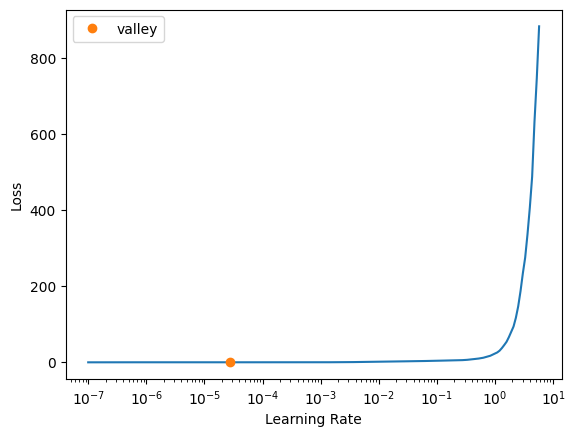

In [35]:
learn.lr_find(stop_div=False, num_it=200)

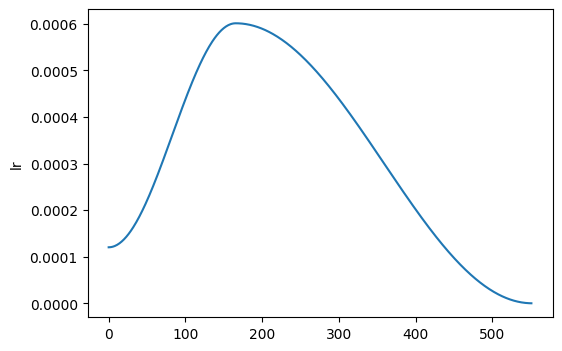

In [36]:
learn.recorder.plot_sched(keys='lr')

In [37]:
learn = vision_learner(dls, convnext_tiny, metrics=accuracy)
learn.freeze()
learn.summary()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential (Input shape: 64 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 96 x 64 x 64   
Conv2d                                    4704       False     
LayerNorm2d                               192        True      
Conv2d                                    4800       False     
____________________________________________________________________________
                     64 x 64 x 64 x 96   
Permute                                                        
LayerNorm                                 192        True      
____________________________________________________________________________
                     64 x 64 x 64 x 384  
Linear                                    37248      False     
GELU                                                           
____________________________________________________________________________
                     64 x 64 x 64 x 96   
Linear                                    36

In [38]:
learn.fit(1, 0.5)

epoch,train_loss,valid_loss,accuracy,time
0,0.000000,0.000000,1.000000,01:17


In [39]:
learn.unfreeze()
learn.fit(3, 0.5)

epoch,train_loss,valid_loss,accuracy,time
0,0.000000,0.000000,1.000000,02:14
1,0.000000,0.000000,1.000000,02:10
2,0.000000,0.000000,1.000000,02:09
